In [262]:
%reload_ext autoreload
%autoreload 2

from collections import Counter
import numpy as np
import pandas as pd
from app import Preprocessing

from matplotlib import pyplot as plt
import torch
import torch.nn as nn

dtype = torch.float
device = torch.device("cpu")

%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [427]:
pre = Preprocessing('IMDB')

In [428]:
pre.data['train_raw'].head()

,text,POS__NEG
0,I watched this film without knowing anything a...,1
1,Spoilers if such a thing is possible As...,0
2,What made the original Killer Tomatoes fun was...,0
3,If you want a serious laugh pain watch this mo...,1
4,Ill admit Ive only watched a handful of episod...,0


In [429]:
len(list(pre.dict))

8691

In [430]:
hans = pre.build_df('train_raw','train',pre.dict)

In [431]:
pre.data['train'].describe().loc[['max'], :].sort_values(by=['max'],axis=1)

,from my,me but,there are no,the sets,them but,film you,and say,br Despite,time as,a word,...,of the,is,a,of,to,and,the,,,
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,50.0,68.0,70.0,80.0,85.0,98.0,176.0,277.0,279.0,281.0


In [432]:
hans = pre.build_df('test_raw','test',pre.dict)

In [433]:
x_test = torch.tensor(pre.data['test'].values).float()
y_test = torch.tensor(pre.get('test_raw')['POS__NEG'].values).long()

In [434]:
x = torch.tensor(pre.data['train'].values).float()
y = torch.tensor(pre.get('train_raw')['POS__NEG'].values).long()

In [435]:
# Logistic regression model
model = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 2)#,
    #torch.nn.Sigmoid()
)

In [436]:
# Hyper-parameters 
learning_rate = 0.01

In [437]:
# Loss and optimizer
# nn.CrossEntropyLoss() computes softmax internally

criterion = nn.CrossEntropyLoss() #nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [438]:
loss_hist = []
# Train
for t in range(1200):
    # Berechne die Vorhersage (foward step)
    outputs = model(x)
    
    # Berechne den Fehler (Ausgabe des Fehlers alle 50 Iterationen)
    loss = criterion(outputs, y)
    
    # Berechne die Gradienten und Aktualisiere die Gewichte (backward step)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Berechne den Fehler (Ausgabe des Fehlers alle 100 Iterationen)
    if t % 20 == 0:
        loss_hist.append(loss.item())
        print(t, loss.item())

0 0.6930063366889954
20 0.5697482824325562
40 0.5135282874107361
60 0.48474183678627014
80 0.465636283159256
100 0.45111149549484253
120 0.4393101930618286
140 0.42933499813079834
160 0.4206825792789459
180 0.41303661465644836
200 0.40619149804115295
220 0.3999883234500885
240 0.39432141184806824
260 0.3891057074069977
280 0.3842744529247284
300 0.3797769546508789
320 0.3755675256252289
340 0.37161675095558167
360 0.3678918480873108
380 0.3643699884414673
400 0.3610288202762604
420 0.35785385966300964
440 0.35483062267303467
460 0.3519408702850342
480 0.3491794168949127
500 0.3465324342250824
520 0.3439897298812866
540 0.34154507517814636
560 0.3391941487789154
580 0.33692601323127747
600 0.3347371518611908
620 0.3326227366924286
640 0.33057695627212524
660 0.3285945653915405
680 0.32667484879493713
700 0.3248133361339569
720 0.3230034112930298
740 0.3212472200393677
760 0.31953737139701843
780 0.31787532567977905
800 0.3162558078765869
820 0.31467729806900024
840 0.31313997507095337
8

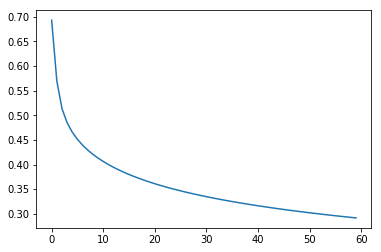

In [439]:
plt.plot(loss_hist);

In [440]:
outputs_test = model(x_test)
#loss = criterion(outputs_test, y_test)
#loss

In [441]:
agg_model = nn.Softmax(dim=1)

In [442]:
y_test_pred_sm = agg_model(outputs_test).argmax(1)

In [443]:
# Klassifikationsgenauigkeit
classification_accuracy_test =(y_test.float() == y_test_pred_sm.float()).float().mean()
classification_accuracy_test

tensor(0.8415)

# Forest classifier

In [388]:
RandomForestClassifier?

In [389]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [390]:
X_train, X_val, y_train, y_val = train_test_split(x.numpy(), y.numpy(), test_size = 0.25)

In [391]:
error_train = []
error_val = []
auc_val = []
auc_train = []

for i in range(50, 60):
    d_forest = RandomForestClassifier(n_estimators=i, n_jobs=-1)
    d_forest.fit(X_train, y_train)
    y_pred_prob_train = d_forest.predict_proba(X_train)
    y_pred_prob_val = d_forest.predict_proba(X_val)
    error_train.append(metrics.mean_squared_error(y_train, y_pred_prob_train[:,1]))
    error_val.append(metrics.mean_squared_error(y_val, y_pred_prob_val[:,1]))

    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_prob_train[:,1])
    auc_train.append(metrics.auc(fpr, tpr))

    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred_prob_val[:,1])
    auc_val.append(metrics.auc(fpr, tpr))

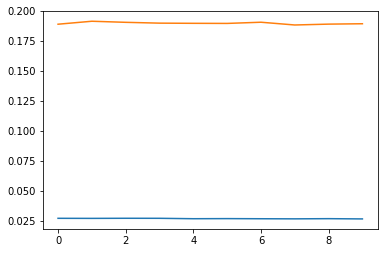

In [392]:
plt.plot(error_train)
plt.plot(error_val)

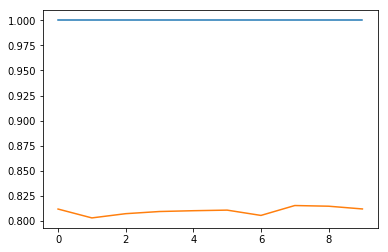

In [393]:
plt.plot(auc_train)
plt.plot(auc_val)

In [394]:
auc_val.index(max(auc_val))

7

In [395]:
error_val.index(min(error_val))

7

In [444]:
d_forest = RandomForestClassifier(n_estimators=57)

In [445]:
d_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=57, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [446]:
y_pred_test = d_forest.predict(x_test)
y_pred_prob_test = d_forest.predict_proba(x_test)

ValueError: Number of features of the model must match the input. Model n_features is 6176 and input n_features is 8691 

In [ ]:
x_test.shape

In [ ]:
y_test.shape

In [ ]:
y_pred_prob_test.shape

In [ ]:
plt.figure(1, figsize=(20,20))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob_test[:,1])
auc = metrics.auc(fpr, tpr)
plt.title('AUC: ' + str(round(auc,4)))
plt.step(fpr, tpr)

plt.show()

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob_test[:,1])

In [ ]:
pd_eval = pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':thresholds})

In [ ]:
# Klassifikationsgenauigkeit
classification_accuracy_test = 1 * (y_test.numpy() == y_pred_test).mean()
classification_accuracy_test

In [ ]:
# Testdatensatz
missclassification_test = 1 * (y_test.numpy() != y_pred_test).mean()
missclassification_test

# 

In [151]:
%%cython --a

cdef int a=5;
cdef int b=6;

b+=a

In [940]:
import re

In [1149]:
#re.findall("([\w][\w']*[\w])","Bromwell High is nothing short of brilliant. Expertly scripted and perfectly delivered, this searing parody of a students and teachers at a South London Public School leaves you literally rolling with laughter. It's vulgar, provocative, witty and sharp. The characters are a superbly caricatured cross section of British society (or to be more accurate, of any society). Following the escapades of Keisha, Latrina and Natella, our three ""protagonists"" for want of a better term, the show doesn't shy away from parodying every imaginable subject. Political correctness flies out the window in every episode. If you enjoy shows that aren't afraid to poke fun of every taboo subject imaginable, then Bromwell High will not disappoint!")

In [1147]:
#re.findall("([\w][\w']*[\w] +[\w][\w']*[\w])","Bromwell High is nothing short of brilliant. Expertly scripted and perfectly delivered, this searing parody of a students and teachers at a South London Public School leaves you literally rolling with laughter. It's vulgar, provocative, witty and sharp. The characters are a superbly caricatured cross section of British society (or to be more accurate, of any society). Following the escapades of Keisha, Latrina and Natella, our three ""protagonists"" for want of a better term, the show doesn't shy away from parodying every imaginable subject. Political correctness flies out the window in every episode. If you enjoy shows that aren't afraid to poke fun of every taboo subject imaginable, then Bromwell High will not disappoint!")

In [1148]:
#re.findall("([\w][\w']*[\w] +[\w][\w']*[\w] +[\w][\w']*[\w])",'Heute ist ein schöner Tag. Lass uns nach draußen gehen.')

In [1152]:
data_df = pd.read_json('/Users/cm/PycharmProjects/IMDB/data/IMDB/amazvideo/Amazon_Instant_Video_5.json', lines=True)

In [1153]:
data_df

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000H00VBQ,"[0, 0]",2,I had big expectations because I love English ...,"05 3, 2014",A11N155CW1UV02,AdrianaM,A little bit boring for me,1399075200
1,B000H00VBQ,"[0, 0]",5,I highly recommend this series. It is a must f...,"09 3, 2012",A3BC8O2KCL29V2,Carol T,Excellent Grown Up TV,1346630400
2,B000H00VBQ,"[0, 1]",1,This one is a real snoozer. Don't believe anyt...,"10 16, 2013",A60D5HQFOTSOM,"Daniel Cooper ""dancoopermedia""",Way too boring for me,1381881600
3,B000H00VBQ,"[0, 0]",4,Mysteries are interesting. The tension betwee...,"10 30, 2013",A1RJPIGRSNX4PW,"J. Kaplan ""JJ""",Robson Green is mesmerizing,1383091200
4,B000H00VBQ,"[1, 1]",5,"This show always is excellent, as far as briti...","02 11, 2009",A16XRPF40679KG,Michael Dobey,Robson green and great writing,1234310400
5,B000H00VBQ,"[12, 12]",5,I discovered this series quite by accident. Ha...,"10 11, 2011",A1POFVVXUZR3IQ,Z Hayes,I purchased the series via streaming and loved...,1318291200
6,B000H0X79O,"[0, 0]",3,"It beats watching a blank screen. However, I j...","10 15, 2013",A1PG2VV4W1WRPL,"Jimmy C. Saunders ""Papa Smurf""",It takes up your time.,1381795200
7,B000H0X79O,"[0, 0]",3,"There are many episodes in this series, so I p...","12 29, 2013",ATASGS8HZHGIB,JohnnyC,A reasonable way to kill a few minutes,1388275200
8,B000H0X79O,"[0, 0]",5,This is the best of the best comedy Stand-up. ...,"02 26, 2014",A3RXD7Z44T9DHW,Kansas,kansas001,1393372800
9,B000H0X79O,"[0, 0]",3,Not bad. Didn't know any of the comedians but...,"04 2, 2014",AUX8EUBNTHIIU,Louis V. Borsellino,Entertaining Comedy,1396396800


In [1044]:
data_test_amzv=np.zeros((data_df.shape[0], len(word_list)))

word1=''
for i in range(data_df.shape[0]):    
     for word in data_df['reviewText'][i].split(" "):
            word2=word
            if word1+' '+word2 in word_list:
                data_test_amzv[i][word_list[word1+' '+word2]]+=word_list[word1+' '+word2]
            word1=word2

In [1046]:
data_test_amzv.describe()

AttributeError: 'numpy.ndarray' object has no attribute 'describe'

In [1047]:
pre.set('amznvideo',pd.DataFrame(data_test_amzv, columns=word_list))

In [1049]:
pre.get('amznvideo').describe()

,the best,a great,like a,movie was,could have,at least,the worst,is very,supposed to,as well,...,his life.,delivers a,any real,why did,the gore,performance and,tribute to,well done.,"/><br />Also,",which she
count,37126.0,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,...,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,37126.0,37126.000000
mean,0.0,0.074638,0.061359,0.024969,0.075634,0.113532,0.038302,0.209664,0.087701,0.217449,...,1.272855,1.129263,1.391154,0.870280,1.219523,0.784706,0.959974,5.968997,0.0,0.933470
std,0.0,0.291203,0.378273,0.291466,0.654096,0.813960,0.491861,1.262011,0.939983,1.508758,...,41.692963,37.409655,38.665064,30.603251,37.926262,29.087883,33.146867,82.047511,0.0,34.636129
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
max,0.0,6.000000,8.000000,6.000000,28.000000,20.000000,12.000000,21.000000,32.000000,27.000000,...,4296.000000,2150.000000,1076.000000,1077.000000,2156.000000,1079.000000,2160.000000,2162.000000,0.0,2166.000000


In [1101]:
x_test_amz_video = torch.tensor(pre.data['amznvideo'].values).float()

In [1102]:
outputs_test_amz = model(x_test_amz_video)

In [1103]:
agg_model = nn.Softmax(dim=1)

In [1138]:
y_amzn=data_df['overall']//3

In [1139]:
y_test_pred_amz = agg_model(outputs_test_amz).argmax(1)

In [1140]:
y_test_pred_amz

tensor([0, 1, 1,  ..., 0, 1, 0])

In [1141]:
y_amzn_tens = torch.tensor(y_amzn)

In [1142]:
y_amzn_tens

tensor([0, 1, 0,  ..., 1, 1, 1])

In [1143]:
hans = (agg_model(outputs_test_amz)*5).long()

In [1144]:
hans[:,1]

tensor([2, 4, 2,  ..., 2, 2, 0])

In [1145]:
# Klassifikationsgenauigkeit
classification_accuracy_test =(y_amzn_tens == y_test_pred_amz).float().mean()
classification_accuracy_test

tensor(0.7956)

In [1146]:
(agg_model(outputs_test_amz)*5).int()

tensor([[2, 2],
        [0, 4],
        [2, 2],
        ...,
        [2, 2],
        [2, 2],
        [4, 0]], dtype=torch.int32)